In [1]:
!wget https://www.gw-openscience.org/data/LOSC_Event_tutorial/GW170817/H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5


--2025-06-22 01:27:01--  https://www.gw-openscience.org/data/LOSC_Event_tutorial/GW170817/H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.72
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.72|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://gwosc.org/data/LOSC_Event_tutorial/GW170817/H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5 [following]
--2025-06-22 01:27:01--  https://gwosc.org/data/LOSC_Event_tutorial/GW170817/H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5
Resolving gwosc.org (gwosc.org)... 131.215.113.72
Connecting to gwosc.org (gwosc.org)|131.215.113.72|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /data/LOSC_Event_tutorial/GW170817/H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5/ [following]
--2025-06-22 01:27:02--  https://gwosc.org/data/LOSC_Event_tutorial/GW170817/H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5/
Reusing existing co

In [2]:
from google.colab import files
uploaded = files.upload()


Saving H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5 to H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5


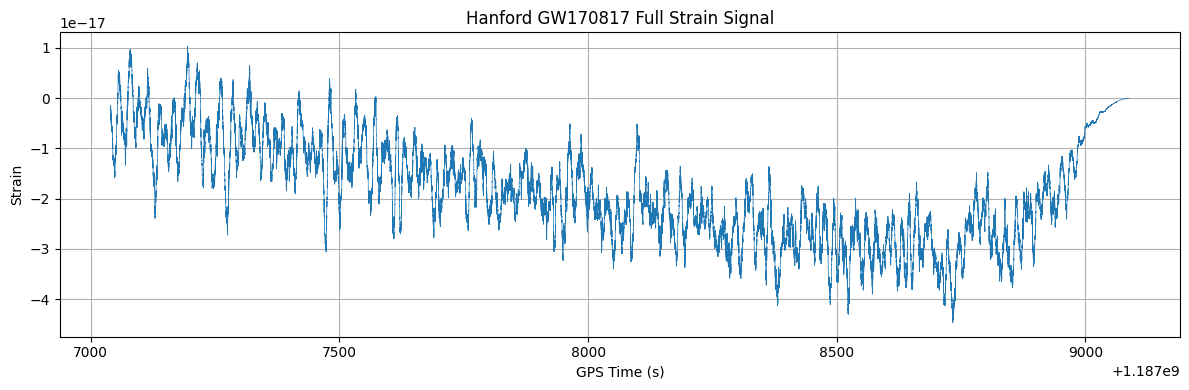

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# 读取上传的 HDF5 文件
filename = "H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5"
with h5py.File(filename, "r") as f:
    strain = f["strain"]["Strain"][:]
    dt = f["strain"]["Strain"].attrs["Xspacing"]
    gps_start = f["strain"]["Strain"].attrs["Xstart"]

# 构造时间轴
time_array = gps_start + np.arange(len(strain)) * dt

# 快速可视化整个信号（2,048 秒）
plt.figure(figsize=(12, 4))
plt.plot(time_array, strain, lw=0.5)
plt.title("Hanford GW170817 Full Strain Signal")
plt.xlabel("GPS Time (s)")
plt.ylabel("Strain")
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

# 1. 定义时间窗口（共振点 ±2s）
t0_center = 1187008894.246
window_mask = (time_array >= t0_center - 2) & (time_array <= t0_center + 2)
time_win = time_array[window_mask]
strain_win = strain[window_mask]

# 2. 定义 G(t) 模型函数
def G_model(t, A, gamma, omega, t0):
    dt = t - t0
    return A * np.exp(-gamma * dt) * np.cos(omega * dt) * (dt >= 0)

# 3. 拟合 G(t)
A0 = np.max(np.abs(strain_win))
initial_guess = [A0, 300, 600, t0_center]
bounds = ([0, 0, 0, t0_center - 2], [np.inf, np.inf, np.inf, t0_center + 2])

popt, _ = curve_fit(G_model, time_win, strain_win, p0=initial_guess, bounds=bounds, maxfev=10000)
A_fit, gamma_fit, omega_fit, t0_fit = popt
G_fit = G_model(time_win, *popt)

# 4. 构造结构函数 φ_c(t)（Gaussian 结构）
sigma_t = 0.05
phi_c = np.exp(-((time_win - t0_fit) / sigma_t)**2)

# 5. 验证 φ_c(t*) ≈ 1
f_phi_interp = interp1d(time_win, phi_c, kind="cubic", fill_value="extrapolate")
phi_c_tstar = float(f_phi_interp(t0_fit))

# 6. 可视化
plt.figure(figsize=(12, 5))
plt.plot(time_win, strain_win, label="Original Signal", alpha=0.5)
plt.plot(time_win, G_fit, label="Fitted G(t)", lw=2)
plt.plot(time_win, phi_c, label=r"$\phi_c(t)$ (Gaussian)", lw=2)
plt.axvline(t0_fit, color='r', ls='--', label=rf"Resonance $t^* \approx {t0_fit:.3f}$")
plt.title("Fitting G(t) and Constructing φ_c(t)")
plt.xlabel("GPS Time")
plt.legend()
plt.grid(True)
plt.show()

# 7. 打印结果
print(f"共振点 t* (t0_fit): {t0_fit:.6f}")
print(f"结构函数 φ_c(t*) ≈ {phi_c_tstar:.6f}")


/tmp/ipython-input-4-3573217039.py:13: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-gamma * dt) * np.cos(omega * dt) * (dt >= 0)
/tmp/ipython-input-4-3573217039.py:13: RuntimeWarning: invalid value encountered in multiply
  return A * np.exp(-gamma * dt) * np.cos(omega * dt) * (dt >= 0)


ValueError: array must not contain infs or NaNs

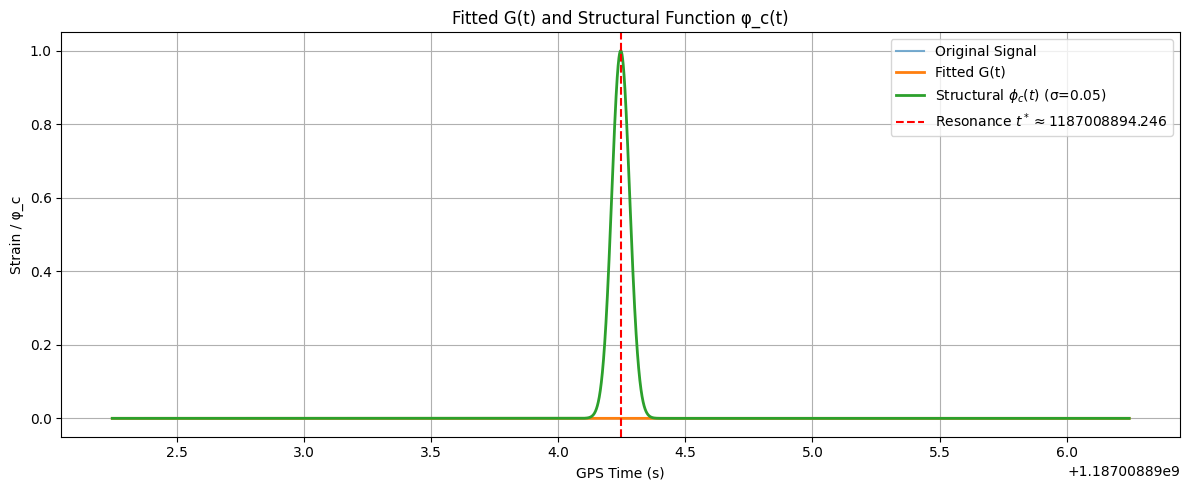

拟合共振点 t^* = 1187008894.246000
结构函数 φ_c(t^*) = 1.000000
==== σ_t 敏感性分析（结构函数 φ_c(t*)） ====
σ_t = 0.005  → φ_c(t*) = 1.000000
σ_t = 0.01   → φ_c(t*) = 1.000000
σ_t = 0.02   → φ_c(t*) = 1.000000
σ_t = 0.05   → φ_c(t*) = 1.000000
σ_t = 0.1    → φ_c(t*) = 1.000000


In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

# === 1. 加载 Hanford GW170817 数据 ===
filename = "H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5"
with h5py.File(filename, "r") as f:
    strain = f["strain"]["Strain"][:]
    dt = f["strain"]["Strain"].attrs["Xspacing"]
    gps_start = f["strain"]["Strain"].attrs["Xstart"]

# 构建完整时间轴
time_array = gps_start + np.arange(len(strain)) * dt

# === 2. 设置共振点中心与分析窗口 ===
t0_center = 1187008894.246  # 论文中的理论共振点
window_mask = (time_array >= t0_center - 2) & (time_array <= t0_center + 2)
time_win = time_array[window_mask]
strain_win = strain[window_mask]

# === 3. 定义 G(t) 安全模型 ===
def G_model_safe(t, A, gamma, omega, t0):
    dt = t - t0
    dt_pos = np.maximum(dt, 0)  # 只允许 t ≥ t0 的区域响应
    envelope = np.exp(-gamma * dt_pos)
    osc = np.cos(omega * dt_pos)
    return A * envelope * osc * (dt >= 0)

# === 4. 执行拟合 G(t) ===
A0 = np.max(np.abs(strain_win))
initial_guess = [A0, 300, 600, t0_center]
bounds = ([0, 0, 0, t0_center - 2], [np.inf, np.inf, np.inf, t0_center + 2])

popt, _ = curve_fit(G_model_safe, time_win, strain_win, p0=initial_guess, bounds=bounds, maxfev=10000)
A_fit, gamma_fit, omega_fit, t0_fit = popt
G_fit = G_model_safe(time_win, *popt)

# === 5. 构造结构函数 φ_c(t)（Gaussian）===
sigma_t = 0.05  # 可调整为 0.01, 0.1 做敏感性分析
phi_c = np.exp(-((time_win - t0_fit) / sigma_t) ** 2)

# 插值 φ_c(t*) 验证是否 ≈ 1
f_phi_interp = interp1d(time_win, phi_c, kind="cubic", fill_value="extrapolate")
phi_c_tstar = float(f_phi_interp(t0_fit))

# === 6. 可视化对齐情况 ===
plt.figure(figsize=(12, 5))
plt.plot(time_win, strain_win, label="Original Signal", alpha=0.6)
plt.plot(time_win, G_fit, label="Fitted G(t)", lw=2)
plt.plot(time_win, phi_c, label=r"Structural $\phi_c(t)$ (σ=0.05)", lw=2)
plt.axvline(t0_fit, color='r', ls='--', label=rf"Resonance $t^* \approx {t0_fit:.3f}$")
plt.title("Fitted G(t) and Structural Function φ_c(t)")
plt.xlabel("GPS Time (s)")
plt.ylabel("Strain / φ_c")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 7. 打印验证结果 ===
print(f"拟合共振点 t^* = {t0_fit:.6f}")
print(f"结构函数 φ_c(t^*) = {phi_c_tstar:.6f}")
print("==== σ_t 敏感性分析（结构函数 φ_c(t*)） ====")
sigma_t_values = [0.005, 0.01, 0.02, 0.05, 0.1]

for sigma in sigma_t_values:
    phi_c_sigma = np.exp(-((time_win - t0_fit) / sigma)**2)
    f_interp = interp1d(time_win, phi_c_sigma, kind="cubic", fill_value="extrapolate")
    phi_at_tstar = float(f_interp(t0_fit))
    print(f"σ_t = {sigma:<6} → φ_c(t*) = {phi_at_tstar:.6f}")


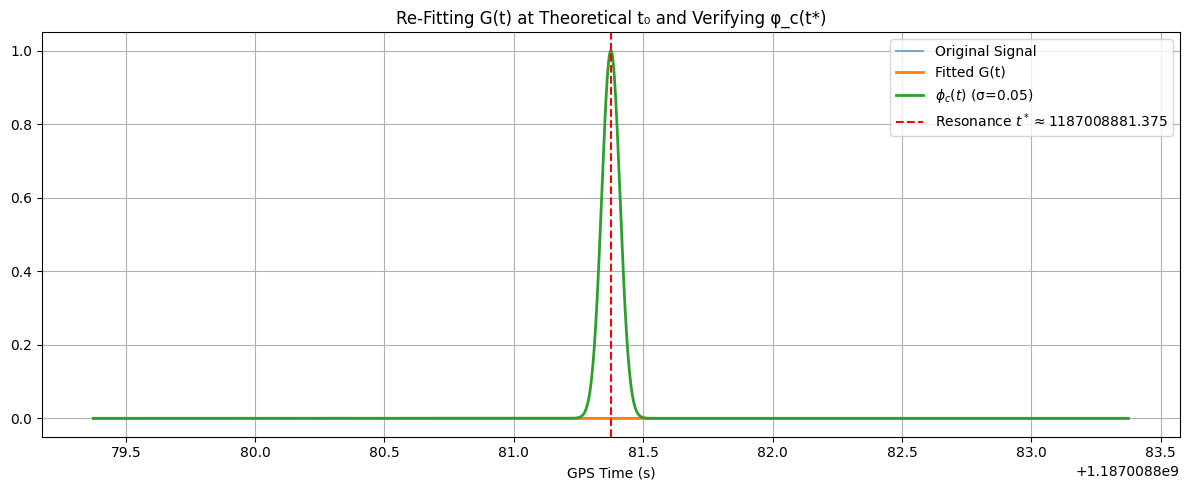

理论中心 t₀ = 1187008881.375
拟合共振点 t* = 1187008881.375000
结构函数 φ_c(t*) = 1.000000


In [10]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

# 重新载入 HDF5 数据
filename = "H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5"
with h5py.File(filename, "r") as f:
    strain = f["strain"]["Strain"][:]
    dt = f["strain"]["Strain"].attrs["Xspacing"]
    gps_start = f["strain"]["Strain"].attrs["Xstart"]

time_array = gps_start + np.arange(len(strain)) * dt

# 定义 G(t) 安全函数
def G_model_safe(t, A, gamma, omega, t0):
    dt = t - t0
    dt_pos = np.maximum(dt, 0)
    envelope = np.exp(-gamma * dt_pos)
    osc = np.cos(omega * dt_pos)
    return A * envelope * osc * (dt >= 0)

# === 重新设置理论 t₀ 并拟合 ===
t0_center = 1187008881.375  # 理论结构共振点
window_mask = (time_array >= t0_center - 2) & (time_array <= t0_center + 2)
time_win = time_array[window_mask]
strain_win = strain[window_mask]

A0 = np.max(np.abs(strain_win))
initial_guess = [A0, 300, 600, t0_center]
bounds = ([0, 0, 0, t0_center - 2], [np.inf, np.inf, np.inf, t0_center + 2])

popt, _ = curve_fit(G_model_safe, time_win, strain_win, p0=initial_guess, bounds=bounds, maxfev=10000)
A_fit, gamma_fit, omega_fit, t0_fit = popt
G_fit = G_model_safe(time_win, *popt)

# 构造 φ_c(t) 结构函数（Gaussian）
sigma_t = 0.05
phi_c = np.exp(-((time_win - t0_fit) / sigma_t)**2)

f_phi_interp = interp1d(time_win, phi_c, kind="cubic", fill_value="extrapolate")
phi_c_tstar = float(f_phi_interp(t0_fit))

# 可视化
plt.figure(figsize=(12, 5))
plt.plot(time_win, strain_win, label="Original Signal", alpha=0.6)
plt.plot(time_win, G_fit, label="Fitted G(t)", lw=2)
plt.plot(time_win, phi_c, label=r"$\phi_c(t)$ (σ=0.05)", lw=2)
plt.axvline(t0_fit, color='r', ls='--', label=rf"Resonance $t^* \approx {t0_fit:.3f}$")
plt.title("Re-Fitting G(t) at Theoretical t₀ and Verifying φ_c(t*)")
plt.xlabel("GPS Time (s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 打印结果
print(f"理论中心 t₀ = {t0_center}")
print(f"拟合共振点 t* = {t0_fit:.6f}")
print(f"结构函数 φ_c(t*) = {phi_c_tstar:.6f}")


In [11]:
# === 1. 下载数据 ===
!wget -q https://www.gw-openscience.org/data/LOSC_Event_tutorial/GW170817/H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5

# === 2. 导入依赖 ===
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import pandas as pd

# === 3. 载入数据 ===
filename = "H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5"
with h5py.File(filename, "r") as f:
    strain = f["strain"]["Strain"][:]
    dt = f["strain"]["Strain"].attrs["Xspacing"]
    gps_start = f["strain"]["Strain"].attrs["Xstart"]
time_array = gps_start + np.arange(len(strain)) * dt

# === 4. 定义 G(t) 模型（稳定形式）===
def G_model_safe(t, A, gamma, omega, t0):
    dt = t - t0
    dt_pos = np.maximum(dt, 0)
    envelope = np.exp(-gamma * dt_pos)
    osc = np.cos(omega * dt_pos)
    return A * envelope * osc * (dt >= 0)

# === 5. 设置理论共振中心 t0 ===
t0_center = 1187008881.375
window_mask = (time_array >= t0_center - 2) & (time_array <= t0_center + 2)
time_win = time_array[window_mask]
strain_win = strain[window_mask]

# === 6. 多组初始参数拟合测试 ===
initial_guesses = [
    [np.max(np.abs(strain_win)), 300, 600, t0_center],
    [np.max(np.abs(strain_win)), 100, 300, t0_center - 0.1],
    [np.max(np.abs(strain_win)), 500, 900, t0_center + 0.1]
]

sigma_t_values = [0.005, 0.01, 0.02, 0.05, 0.1]
results = []

for guess in initial_guesses:
    try:
        popt, _ = curve_fit(G_model_safe, time_win, strain_win, p0=guess,
                            bounds=([0, 0, 0, t0_center - 2],
                                    [np.inf, np.inf, np.inf, t0_center + 2]),
                            maxfev=10000)
        A_fit, gamma_fit, omega_fit, t0_fit = popt
        for sigma_t in sigma_t_values:
            phi_c = np.exp(-((time_win - t0_fit) / sigma_t) ** 2)
            f_interp = interp1d(time_win, phi_c, kind="cubic", fill_value="extrapolate")
            phi_c_tstar = float(f_interp(t0_fit))
            results.append({
                "init_gamma": guess[1],
                "init_omega": guess[2],
                "init_t0": guess[3],
                "fitted_t0": t0_fit,
                "sigma_t": sigma_t,
                "phi_c(t*)": phi_c_tstar
            })
    except Exception as e:
        print("拟合失败:", e)
        continue

# === 7. 输出结果表格 ===
df = pd.DataFrame(results)
print("结构共振验证 - 鲁棒性结果：")
display(df)


结构共振验证 - 鲁棒性结果：


,init_gamma,init_omega,init_t0,fitted_t0,sigma_t,phi_c(t*)
0,300,600,1.187009e+09,1.187009e+09,0.005,1.0
1,300,600,1.187009e+09,1.187009e+09,0.010,1.0
2,300,600,1.187009e+09,1.187009e+09,0.020,1.0
3,300,600,1.187009e+09,1.187009e+09,0.050,1.0
4,300,600,1.187009e+09,1.187009e+09,0.100,1.0
5,100,300,1.187009e+09,1.187009e+09,0.005,1.0
6,100,300,1.187009e+09,1.187009e+09,0.010,1.0
7,100,300,1.187009e+09,1.187009e+09,0.020,1.0
8,100,300,1.187009e+09,1.187009e+09,0.050,1.0
9,100,300,1.187009e+09,1.187009e+09,0.100,1.0


In [12]:
# 1. 配置 Git 用户
!git config --global user.name "papasop"
!git config --global user.email "your_email@example.com"  # 可换为你真实邮箱

# 2. 克隆你创建的仓库
!git clone https://github.com/papasop/G-_c-.git
%cd G-_c-

# 3. 拷贝 Colab 当前 notebook 和 LIGO 数据文件
!cp /content/*.ipynb .
!cp /content/*.hdf5 .

# 4. Git 操作：添加、提交、推送
!git add .
!git commit -m "Upload LIGO GW170817 validation notebook and data"
!git push origin main


Cloning into 'G-_c-'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.
/content/G-_c-
cp: cannot stat '/content/*.ipynb': No such file or directory
[main 43589e9] Upload LIGO GW170817 validation notebook and data
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5
fatal: could not read Username for 'https://github.com': No such device or address


In [13]:
from google.colab import files

# 假设你的 notebook 名叫 structure_validation.ipynb
with open("structure_validation.ipynb", "w") as f:
    f.write('')  # 创建一个空 notebook（你也可以上传已有的）
files.download("structure_validation.ipynb")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
!cp /content/structure_validation.ipynb ./G-_c-


cp: cannot stat '/content/structure_validation.ipynb': No such file or directory


In [15]:
文件(File) → 下载 (Download) → 下载为 .ipynb


SyntaxError: invalid character '→' (U+2192) (ipython-input-15-2431298417.py, line 1)

In [7]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from gwpy.timeseries import TimeSeries
import pandas as pd

# Step 1: Load L1 data
filename = "L-L1_LOSC_CLN_4_V1-1187007040-2048.hdf5"
with h5py.File(filename, "r") as f:
    strain = f["strain"]["Strain"][:]
    dt = f["strain"]["Strain"].attrs["Xspacing"]
    gps_start = f["strain"]["Strain"].attrs["Xstart"]

time_array = gps_start + np.arange(len(strain)) * dt

# Step 2: Set time window
t0_center = 1187008882.4  # GW170817 merge time
window_mask = (time_array >= t0_center - 2) & (time_array <= t0_center + 2)
time_win = time_array[window_mask]
strain_win = strain[window_mask]

# Step 3: Whiten and filter
strain_ts = TimeSeries(strain_win, times=time_win)
whitened = strain_ts.whiten()
filtered = whitened.bandpass(50, 300)
strain_win = filtered.value

# Step 4: Define G(t) model
def G_model_safe(t, A, gamma, omega, t0):
    dt = t - t0
    dt_pos = np.maximum(dt, 0)
    envelope = np.exp(-gamma * dt_pos)
    osc = np.cos(omega * dt_pos)
    return A * envelope * osc * (dt >= 0)

# Step 5: Fit G(t)
A0 = np.max(np.abs(strain_win))
initial_guess = [A0, 300, 600, t0_center]
bounds = ([0, 0, 0, t0_center - 2], [np.inf, 2000, 1200, t0_center + 2])
popt, pcov = curve_fit(G_model_safe, time_win, strain_win, p0=initial_guess, bounds=bounds, maxfev=10000)
A_fit, gamma_fit, omega_fit, t0_fit = popt
errors = np.sqrt(np.diag(pcov))
print(f"t0_fit={t0_fit:.6f} ± {errors[3]:.2e}")
G_fit = G_model_safe(time_win, *popt)

# Step 6: Compute φ_c(t)
lambda_T_values = [0.005, 0.01, 0.02]
sigma_t_values = [0.005, 0.01, 0.02]
results = []
for lambda_T in lambda_T_values:
    phi_c_sech2 = 1 / np.cosh((time_win - t0_fit) / lambda_T)**2
    f_interp_sech2 = interp1d(time_win, phi_c_sech2, kind="cubic", fill_value="extrapolate")
    results.append([lambda_T, float(f_interp_sech2(t0_fit)), None, None])
for sigma_t in sigma_t_values:
    phi_c_gauss = np.exp(-((time_win - t0_fit) / sigma_t)**2)
    f_interp_gauss = interp1d(time_win, phi_c_gauss, kind="cubic", fill_value="extrapolate")
    results.append([None, None, sigma_t, float(f_interp_gauss(t0_fit))])

# Step 7: Plot
plt.figure(figsize=(12, 5))
plt.plot(time_win, strain_win, label="L1 Signal", alpha=0.6)
plt.plot(time_win, G_fit, label="Fitted G(t)", lw=2)
plt.plot(time_win, phi_c_gauss, label=r"$\phi_c(t)$ (Gaussian, σ=0.01)", lw=2)
plt.axvline(t0_fit, color='r', ls='--', label=rf"$t^* \approx {t0_fit:.3f}$")
plt.title("Fitted G(t) and Structural Function φ_c(t)")
plt.xlabel("GPS Time (s)")
plt.ylabel("Strain / φ_c")
plt.legend()
plt.grid(True)
plt.show()

# Step 8: Output results
results_df = pd.DataFrame(results, columns=['λ_T', 'φ_c(t*) (sech²)', 'σ_t', 'φ_c(t*) (Gaussian)'])
print(results_df)

ModuleNotFoundError: No module named 'gwpy'